<img align="right" style="margin:0 0 20px 20px" width="25%" height="25%" src="https://csdms.colorado.edu/csdms_wiki/images/OpenEarthscape_logo.png">

This tutorial illustrates how to model the transport of coarse sediment through a highly simplified synthetic river network (a simple 1D 'flume') using the [NetworkSedimentTransporter Landlab component](https://joss.theoj.org/papers/10.21105/joss.02341). This notebook is a condensed example of many of the [Landlab tutorials associated with the NetworkSedimentTransporter](https://landlab.csdms.io/generated/tutorials/index.html).


In this example we will: 
- create a synthetic *Landlab grid*, mimicing a river-scale flume of uniform conditions
- create *sediment “parcels”* that will transport through the river network, represented as items in a Landlab DataRecord
- run the component in 3 configurations:
    1. baseline run
    2. recycling bed material
    3. adding a pulse of sediment
- plot the results of the model run

First, let's import the necessary libraries:

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl 

import numpy as np
import pandas as pd

from landlab.components import (
    FlowDirectorSteepest,
    NetworkSedimentTransporter,
    BedParcelInitializerDepth,
)

from landlab.grid.network import NetworkModelGrid


### *i. Create the river network model grid*
First, we need to create a Landlab NetworkModelGrid to represent the river network. Each link on the grid represents a reach of river. Each node represents a break between reaches. Here, we'll take a very simple approach, creating a single channel (i.e. no tributaries) of evenly spaced nodes. 

In [2]:
link_len = 100  # meters 
num_links = 15

x_of_node = np.arange(0, link_len*num_links+1, link_len) # x and y coordinates of nodes
y_of_node = np.ones_like(x_of_node)  # x and y coordinates of nodes

nodes_at_link = []
for i in range(np.size(y_of_node)-1):
    nodes_at_link.append((i, i+1))

grid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)

Our network consists of 15 links between 16 nodes. X and Y, above, represent the plan-view coordinates of the node locations. `nodes_at_link` describes the node indices that are connedted by each link. Note: this manual approach to grid creation would be cumbersome for a more complicated network. For those cases, see the other example notebook in this repository, which includes an example of reading in a shapefile. 

### *ii. Populate the grid with river channel parameters*

Next, we need to populate the grid with the relevant topographic and flow information. 

We must define both topographic elevation (the top surface of the bed sediment) and bedrock elevation (the surface of the river in the absence of modeled sediment). Note that `topographic__elevation` will be updated at each model timestep depending on how much sediment is present. 

Also note that `reach_length` is defined by the user, rather than calculated as the minimum distance between nodes. This accounts for channel sinuosity.

In [3]:
# channel characteristics
channel_slope = 0.01
channel_width = 5 # m
flow_depth = 1 # m

# topographic information
grid.at_link["flow_depth"] = flow_depth * np.ones(grid.number_of_links)  # m
grid.at_link["reach_length"] = link_len * np.ones(grid.number_of_links) # m
grid.at_link["channel_width"] = channel_width * np.ones(grid.number_of_links)  # m
    
grid.at_link["channel_slope"] = channel_slope * np.ones(grid.number_of_links)  # 

grid.at_node["topographic__elevation"] = channel_slope*(link_len*num_links-x_of_node) # Gets updated with sed thickness at first timestep
grid.at_node["bedrock__elevation"] = grid.at_node["topographic__elevation"].copy() # Remains constant


Take a moment to look at the syntax for the landlab grid: for each variable, we specify whether it is held on a node (`grid.at_node['example_var']`) or link(`grid.at_link['example_var']`). 

Also note that the indexing will not necessarily match the ordering of the inputs above (e.g. `x_of_node`). Landlab re-orders the links/nodes spatially, starting with the grid element at the lower left and working up. See [this Landlab tutorial](https://landlab.csdms.io/tutorials/grids/diverse_grid_classes.html) for more details. 

## *iii. Create parcels to represent sediment on the bed*

First, we have to establish flow direction along our grid using the Landlab `FlowDirectorSteepest` component. Then, we use the handy dandy `BedParcelInitializerDepth` to automatically create parcels of sensible grain size distributions for each link of our river network based on a simple Shields stress approximation. 

In [4]:
# flow direction
fd = FlowDirectorSteepest(grid, "topographic__elevation")
fd.run_one_step()

initialize_parcels = BedParcelInitializerDepth(
    grid,
    flow_depth_at_link=grid.at_link["flow_depth"],
    tau_c_multiplier=1.5, # values >1 create a more mobile bed, see Pfeiffer et al. 2017, PNAS
    D84_D50 = 1, # create a narrow GSD (D84/D50 ~ 1.5)
    median_number_of_starting_parcels=100, 
    extra_parcel_attributes=["source"] # tagging the parcel source, for use below
)

parcels = initialize_parcels()

parcels.dataset["source"].values = np.full(parcels.number_of_items, "initial_bed_sed") 


Let's take a moment to look at the syntax of the parcels, which are an instance of the landlab `DataRecord`. We can reference parcel attributes and index them by parcel. As we run the `NetworkSedimentTransporter`, some attributes get tracked through time as well. These attributes are indexed via `[parcel_index, timestep]`.

In [5]:
print('Parcel median grain size is ', np.nanmedian(parcels.dataset["D"].values),' m') 
print('In the last (and only, for now) timestep, the first parcel is on link ', parcels.dataset['element_id'].values[0,-1]) # parcel indexing: [parcel_index,timestep]
print('We have created ',parcels.number_of_items, ' parcels on the grid')

Parcel median grain size is  0.101010101010101  m
In the last (and only, for now) timestep, the first parcel is on link  0
We have created  1500  parcels on the grid


## *iv. Initialize the `NetworkSedimentTransporter` component and set up for model run*


In [6]:
# %%initialize the networksedimentTransporter
nst = NetworkSedimentTransporter(
    grid,
    parcels,
    fd,
    active_layer_method = "Constant10cm",
)

Now that we've filled our numerical flume, let's run it...

# Configuration 1: run the NST with no feed

In [7]:
# Run time
timesteps = 50
dt = 60*60*24*5  # (seconds)

# set up a few variables for plotting: 
Elev_change = np.empty([grid.number_of_nodes,timesteps])*np.nan

for t in range(0, (timesteps*dt), dt):

    nst.run_one_step(dt)

    # For plotting...
    if t == 0:
        elev_initial = grid.at_node["topographic__elevation"].copy() 
        
    Elev_change[:,np.int64(t/dt)] = grid.at_node['topographic__elevation']-elev_initial


We'll make a simple plot of elevation change through time and space.

Text(0, 0.5, 'link downstream --->')

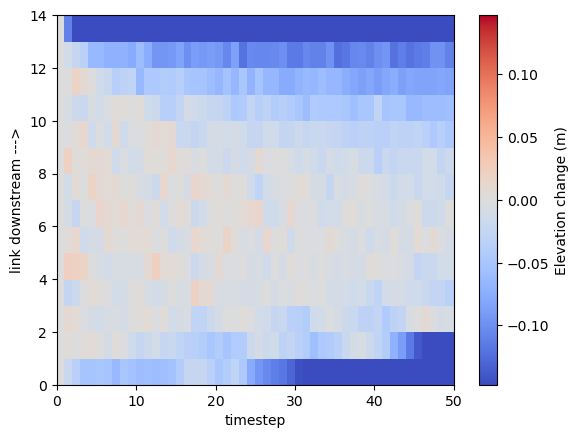

In [8]:
plt.pcolor(Elev_change[1:-1,:],cmap = 'coolwarm', norm = mpl.colors.CenteredNorm()) # cut off edge effects ds
plt.colorbar(label = 'Elevation change (m)')
plt.xlabel('timestep')
plt.ylabel('link downstream --->')

Reminder: if you re-run this, you'll need to start from the top so you don't accumulate change in the parcels and grid. In the top bar, select Kernel --> "Restart the Kernel and Run up to Selected Cell..."

# Configuration 2: Recycle bed sediment that exits the downstream end

Now, we'll run the same model, but 'recycle' sediment that exits the downstream end into an upper link. Conceptually, we can think of this as mimicking a recirculating flume, and will keep us from flushing our channel free of sediment. Computationally, this 'recycling' greatly reduces the memory needs of the model. Because parcels are tracked in time and space for the duration of the model run, creating new parcels to feed in to the upstream end (rather than reusing the existing ones) would increase the run time and the memory needs. 

Here, I'm recycling to link 1 (rather than 0) to prevent buildup. 


In [9]:
OUT_OF_NETWORK = NetworkModelGrid.BAD_INDEX - 1 

In [10]:
parcels = initialize_parcels()
parcels.dataset["source"].values = np.full(parcels.number_of_items, "initial_bed_sed") 
nst = NetworkSedimentTransporter(
    grid,
    parcels,
    fd,
    active_layer_method = "Constant10cm",
)

# Run time
timesteps = 100  
dt = 60*60*24*5  # seconds

# set up a few variables for plotting: 
Elev_change = np.empty([grid.number_of_nodes,timesteps])*np.nan


for t in range(0, (timesteps*dt), dt):

    ##### New: Recycle sediment ###############   
    mask_exited = parcels.dataset.element_id.values[:,-1] == OUT_OF_NETWORK # mask to select parcels that have exited the grid
    
    parcels.dataset.starting_link.values[mask_exited] = OUT_OF_NETWORK # denote it was recycled: starting link = outlet
    parcels.dataset.location_in_link.values[mask_exited, -1] = 0. # place at upstream most end of link (could also distribute randomly..)
    parcels.dataset.element_id.values[mask_exited,-1] = 1 # move it to the 2nd to upstream most link (happens to be index 1)
    ######################################  
    
    # Run one step
    nst.run_one_step(dt)

    Elev_change[:,np.int64(t/dt)] = grid.at_node['topographic__elevation']-elev_initial


Text(0, 0.5, 'link downstream --->')

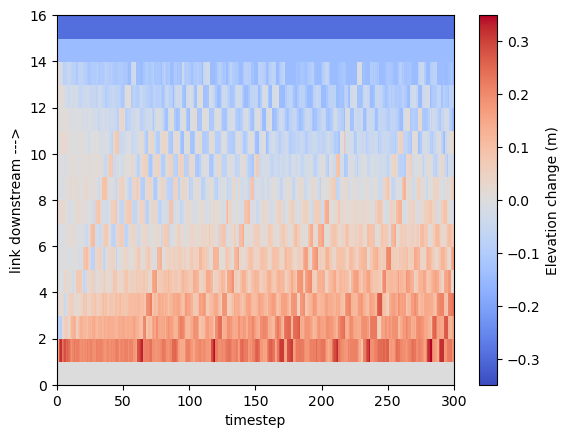

In [11]:
plt.pcolor(Elev_change,cmap = 'coolwarm', norm = mpl.colors.CenteredNorm()) # cut off edge effects ds
plt.colorbar(label = 'Elevation change (m)')
plt.xlabel('timestep')
plt.ylabel('link downstream --->')

Now, try increasing the number of timesteps (try 300) to see if our flume approaches an equilibrium

# Configuration 3: Add a sediment pulse

In [12]:
# pulse characteristics 
num_pulse_parcels = 200
pulse_time = 50 # timestep when pulse is added
pulse_link = 5

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
parcels = initialize_parcels()
parcels.dataset["source"].values = np.full(parcels.number_of_items, "initial_bed_sed") 
nst = NetworkSedimentTransporter(
    grid,
    parcels,
    fd,
    active_layer_method = "Constant10cm",
)

# Run time
timesteps = 100  
dt = 60*60*24  # (seconds)

# set up a few variables for plotting: 
Elev_change = np.empty([grid.number_of_nodes,timesteps])*np.nan

for t in range(0, (timesteps*dt), dt):
    
    if t == 0: # For plotting...
        elev_initial = grid.at_node["topographic__elevation"].copy() 
        
    # Recycle only bed sediment
    mask_exited = parcels.dataset.element_id.values[:,-1] == OUT_OF_NETWORK
    mask_initial_bed = parcels.dataset.source == "initial_bed_sed" 
    
    parcels.dataset.starting_link.values[mask_exited & mask_initial_bed] = -2 # way to denote it was recycled
    parcels.dataset.location_in_link.values[mask_exited & mask_initial_bed,-1] = 0. # place at upstream most end of link (could also distribute randomly..)
    parcels.dataset.element_id.values[mask_exited & mask_initial_bed,-1] = 1 # move it to the upstream most link (happens to be index 0)

    ##### New: Add a single pulse ####### 
    if t==dt*pulse_time: 

        new_variables = {
            "starting_link": (["item_id"], np.ones(num_pulse_parcels)*pulse_link),
            "source": (["item_id"],  num_pulse_parcels * ["pulse"]),
            "time_arrival_in_link": (["item_id", "time"], np.ones((num_pulse_parcels,1))*nst._time_idx),
            "active_layer": (["item_id", "time"], np.ones((num_pulse_parcels,1))),
            "density": (["item_id"], np.ones(num_pulse_parcels)*2650),
            "abrasion_rate": (["item_id"],np.ones(num_pulse_parcels)*0),
            "location_in_link": (["item_id", "time"], np.random.rand(num_pulse_parcels, 1)), # 
            "D": (["item_id", "time"], np.ones((num_pulse_parcels,1))*0.08), # Grain size
            "volume": (["item_id", "time"], np.ones((num_pulse_parcels,1))*2), # m3
            }
        
        newpar_element_id = np.full((num_pulse_parcels, 1), pulse_link, dtype=int)
        
        newpar_grid_elements = np.full_like(newpar_element_id, "link", dtype=object)

        new_parcels = {
            "grid_element": newpar_grid_elements,
            "element_id": newpar_element_id,
        }
        
        parcels.add_item(
            time=[nst._time],
            new_item = new_parcels,
            new_item_spec = new_variables
            )
    ##########################  
    
    nst.run_one_step(dt)

    Elev_change[:,np.int64(t/dt)] = grid.at_node['topographic__elevation']-elev_initial


Text(0, 0.5, 'link downstream --->')

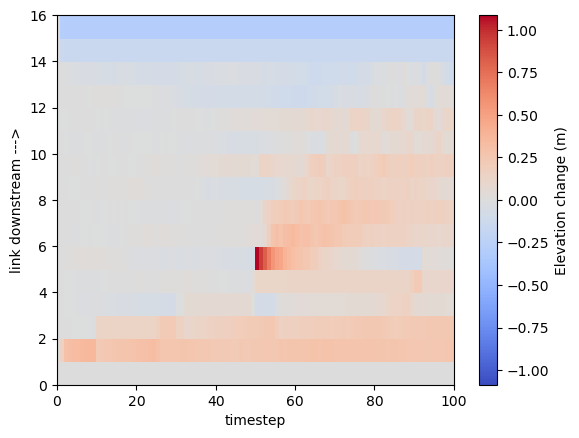

In [15]:
plt.pcolor(Elev_change,cmap = 'coolwarm', norm = mpl.colors.CenteredNorm())
plt.colorbar(label = 'Elevation change (m)')
plt.xlabel('timestep')
plt.ylabel('link downstream --->')

Text(0.5, 0, 'timestep')

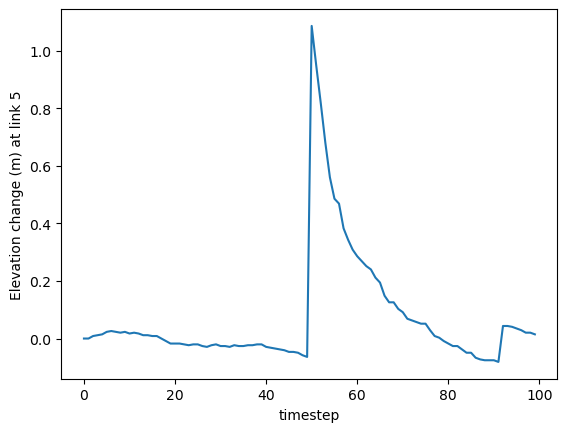

In [16]:
# line plot to explore
plt.plot(Elev_change[pulse_link,:])
plt.ylabel('Elevation change (m) at link '+ str(pulse_link))
plt.xlabel('timestep')

### Your turn to explore the results

In addition to `Elev_change`, we can easily plot many other `at_link` variables. 

Take a few minutes to **edit the code above** with some of the following `at_link` variables. Don't forget to create the empty array before the for loop. 

In [17]:
# Create the empty arrays to start out
Slope = np.empty([grid.number_of_links,timesteps])*np.nan # example empty 2D array for an at_link variable through time
Active_d_mean = np.empty([grid.number_of_links,timesteps])*np.nan 
Sand_fraction_active = np.empty([grid.number_of_links,timesteps])*np.nan 

# In the loop through time, add:
Slope[:,np.int64(t/dt)] = grid.at_link['channel_slope']

Active_d_mean[:,np.int64(t/dt)]= nst.d_mean_active

Sand_fraction_active[:,np.int64(t/dt)] = grid.at_link["sediment__active__sand_fraction"]

We can also use the `DataRecord` `aggregators` to calculate parcel statistics that are aggregated by link. 

In [23]:
from landlab.data_record.aggregators import (aggregate_items_as_sum, aggregate_items_as_mean, aggregate_items_as_count)

# mask and find elements of active pulse parcels
mask_active = parcels.dataset.active_layer[:,-1]==1
element_all_parcels = parcels.dataset.element_id.values[:, -1].astype(int)
element_active_pulse= element_all_parcels[mask_active & ~mask_initial_bed]

# Aggregate sum of parcel values on a link
Pulse_volume = aggregate_items_as_sum( 
            element_all_parcels[~mask_initial_bed], # the grid element id (location) of pulse parcels
            parcels.dataset.volume.values[~mask_initial_bed,-1], # the attribute to be aggregated: volume, last timestep
            size = grid.number_of_links # output will be of size number_of_links
        )

# Aggregate by mean parcel values on a link
D_mean_pulse_each_link = aggregate_items_as_mean(
    element_all_parcels[~mask_initial_bed],
    parcels.dataset.D.values[~mask_initial_bed,-1],
    weights = parcels.dataset.volume.values[~mask_initial_bed, -1],
    size = grid.number_of_links,
) # Ok, in our example the result is boring, since the pulse is uniform... 

# Aggregate by counting parcels of particular characteristics (active, pulse) on a link
Num_active_pulse = aggregate_items_as_count(
    element_active_pulse,
    size = grid.number_of_links
)

In the examples above we're exploring parcel volume, but these aggregators can be used for any parcel attributes. You could calculate (for example) parcel mean Be-10 concentration in only the sand fraction.

A handful of other variables you might want to explore

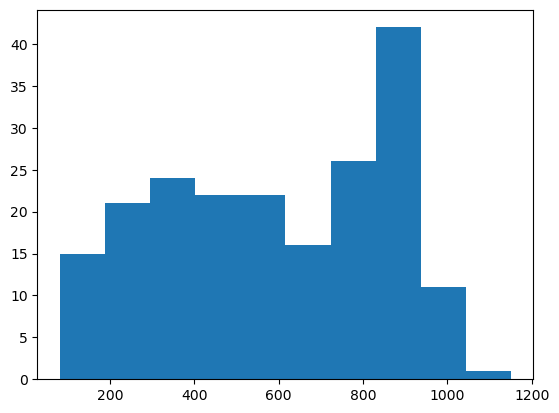

<xarray.DataArray 'D' (item_id: 200)> Size: 2kB
array([1.90547093, 1.64976962, 1.90547093, 1.90547093, 1.87780481,
       1.87780481, 1.90547093, 1.90547093, 1.64976962, 1.87780481,
       1.90927362, 1.90547093, 1.90547093, 1.87780481, 1.90547093,
       1.87780481, 1.87780481, 1.90927362, 1.90547093, 2.16971294,
       1.90547093, 1.87780481, 1.87780481, 1.87780481, 1.90547093,
       1.90547093, 2.16971294, 2.16971294, 1.87780481, 2.16971294,
       1.90927362, 1.90927362, 2.16971294, 1.90927362, 2.16971294,
       1.87780481, 2.16971294, 2.16971294, 1.90927362, 1.90927362,
       2.16971294, 1.90927362, 2.16971294, 2.16971294, 2.16971294,
       2.16971294, 2.16971294, 2.16971294, 1.90927362, 2.16971294,
       2.09411502, 2.16971294, 2.09411502, 1.90927362, 2.09411502,
       2.09411502, 2.09411502, 2.09411502, 2.09411502, 2.09411502,
       2.16971294, 2.09411502, 2.09411502, 2.09411502, 2.09411502,
       2.09411502, 2.18894605, 2.18894605, 2.09411502, 2.18894605,
       2.18894605, 2.18894605, 2.18894605, 2.18894605, 2.18894605,
       2.18894605, 2.09411502, 2.18894605, 2.09411502, 2.16971294,
       2.18894605, 2.18894605, 2.18894605, 2.18894605, 2.18894605,
       2.18894605, 2.18894605, 2.18894605, 2.18894605, 2.18894605,
       2.41081545, 1.90927362, 2.41081545, 2.41081545, 2.41081545,
       2.18894605, 2.41081545, 2.41081545, 2.18894605, 2.41081545,
       1.90927362, 2.41081545, 2.41081545, 2.41081545, 1.90927362,
       2.41081545, 2.41081545, 2.41081545, 2.41081545, 1.90927362,
       2.09411502, 2.41081545, 2.41081545, 2.09411502, 2.41081545,
       2.41081545, 2.41081545, 2.16971294, 2.09411502, 2.09411502,
       2.18894605, 2.09411502, 2.09411502, 2.16971294, 2.16971294,
       1.90927362, 2.18894605, 1.90927362, 2.41081545, 2.09411502,
       2.16971294, 2.41081545, 2.41081545, 2.41081545, 1.94035203,
       1.94035203, 2.16971294, 2.0630516 , 1.94035203, 1.94035203,
       2.41081545, 1.94035203, 1.90927362, 1.90927362, 1.90927362,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 2.0630516 ,
       2.0630516 ,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 1.94035203,
       2.0630516 , 1.94035203, 2.0630516 , 2.0630516 ,        nan])
Coordinates:
    time     float64 8B 8.64e+06
  * item_id  (item_id) int64 2kB 1499 1500 1501 1502 ... 1695 1696 1697 1698

In [27]:
active_layer_volume = nst._active_layer_thickness *grid.at_link['channel_width']*link_len

#plt.hist(nst._distance_traveled_cumulative)
plt.hist(nst._distance_traveled_cumulative[-num_pulse_parcels:])
plt.show()

nst._tautaur[-num_pulse_parcels:]

Acknowledge: OpenEarthscape, NSF LithSedPulse 

# Everything below here is scratch... combine/tidy

Other tricks notebook:
- animation of bed wave
- visualizing parcel by parcel 

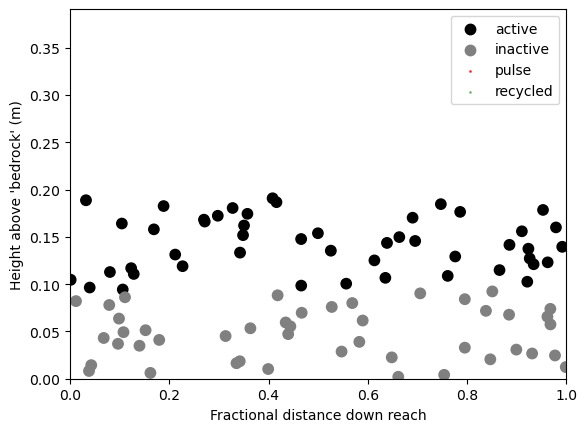

In [27]:
# Plotting parcels in a link

tstep = 50
link = 10

mask_here = parcels.dataset.element_id.values[:,tstep] == link 

time_arrival = parcels.dataset.time_arrival_in_link.values[mask_here, tstep]
volumes = parcels.dataset.volume.values[:, tstep]

current_link = parcels.dataset.element_id.values[:,tstep].astype(int)    
this_links_parcels = np.where(current_link == link)[0]

time_arrival_sort =np.argsort(time_arrival,0,)
parcel_id_time_sorted = this_links_parcels[time_arrival_sort]

# Order variables first in last out
vol_ordered_filo = volumes[parcel_id_time_sorted]
cumvol_orderedfilo = np.cumsum(volumes[parcel_id_time_sorted])
effectiveheight_orderedfilo = cumvol_orderedfilo/(grid.at_link["channel_width"][link]*grid.at_link["reach_length"][link])
source_orderedfilo = parcels.dataset.source[parcel_id_time_sorted]
active_orderedfilo = parcels.dataset.active_layer[parcel_id_time_sorted,tstep]
location_in_link_orderedfilo = parcels.dataset.location_in_link.values[parcel_id_time_sorted,tstep]
D_orderedfilo = parcels.dataset.D.values[parcel_id_time_sorted,tstep]
starting_link_orderedfilo = parcels.dataset.starting_link.values[parcel_id_time_sorted]


plt.scatter(location_in_link_orderedfilo[active_orderedfilo==1],
            effectiveheight_orderedfilo[active_orderedfilo==1],
            D_orderedfilo[active_orderedfilo==1]*500+5,
            'k',
            label = 'active')  

plt.scatter(location_in_link_orderedfilo[active_orderedfilo==0],
            effectiveheight_orderedfilo[active_orderedfilo==0],
            D_orderedfilo[active_orderedfilo==0]*500+5,
            'grey',
            label ='inactive' )

# Shade all pulse red/pink
plt.scatter(location_in_link_orderedfilo[source_orderedfilo=='pulse'],
            effectiveheight_orderedfilo[source_orderedfilo=='pulse'],
            D_orderedfilo[source_orderedfilo=='pulse']*500+5,
            'r',
            alpha=0.7,
            label = 'pulse')  

# Shade all recycled green
plt.scatter(location_in_link_orderedfilo[starting_link_orderedfilo==OUT_OF_NETWORK],
            effectiveheight_orderedfilo[starting_link_orderedfilo==OUT_OF_NETWORK],
            D_orderedfilo[starting_link_orderedfilo==OUT_OF_NETWORK]*500+5,
            color = 'forestgreen',
            alpha=0.5,
            label='recycled')  

plt.ylim(0,np.max(effectiveheight_orderedfilo)+0.2)
plt.xlim(0,1)
plt.xlabel('Fractional distance down reach')
plt.ylabel("Height above 'bedrock' (m)")
plt.legend()

plt.show()
